<a href="https://colab.research.google.com/github/almazav/Masters-Project/blob/main/GNN_course4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Embedding methods 2
## Node2Vec
Variation of deep Walk teh difference is how $S_G$ is define. In a Deep Walk the random walk is Unbias whereas in the Node2Vec we use a Bias random walk.
<br>How to explore networks: 
* Depth-firts search(DFS): explore graph as far as possible. Global
* Breath-first search(BFS): stay as local as possible to the node. Local 
 

## Node2Vec example Karate Club

In [2]:
#pip install karateclub

In [4]:
import networkx as nx 
from karateclub import Node2Vec 
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

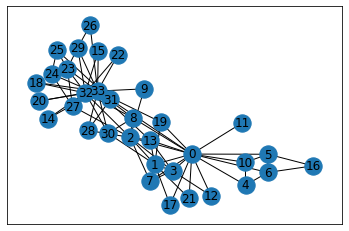

In [6]:
#load data
G = nx.karate_club_graph()
nx.draw_networkx(G)

In [10]:
##create labels
labels = []
for i in G.nodes:
  club_names = G.nodes[i]['club']
  labels.append(1 if club_names=='Officer' else 0)

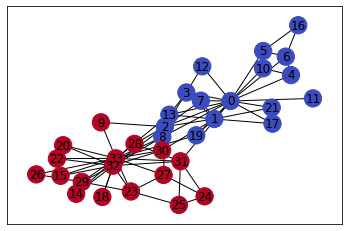

In [11]:
#plot nodes difference
layout_pos = nx.spring_layout(G)
nx.draw_networkx(G,pos=layout_pos,node_color=labels,cmap='coolwarm')

In [12]:

#perform embedding using node2vec https://karateclub.readthedocs.io/en/latest/notes/introduction.html?highlight=deepwalk
#bias parameters q stay local, p go global
N2vec_model = Node2Vec(walk_number=10,walk_length=80,p=0.6,q=0.4,dimensions= 124)
N2vec_model.fit(G)
embedding = N2vec_model.get_embedding()

In [13]:
print(f'Node2Vec embedding (nodesXfeatures): {embedding.shape}')

Node2Vec embedding (nodesXfeatures): (34, 124)


In [14]:
#perform principal componet analysis 
PCA_model = sklearn.decomposition.PCA(n_components=2)
lowdimension_embedding = PCA_model.fit_transform(embedding)
print(f'Node2Vec low dimesndion embedding (nodesX2): {lowdimension_embedding.shape}')

Node2Vec low dimesndion embedding (nodesX2): (34, 2)


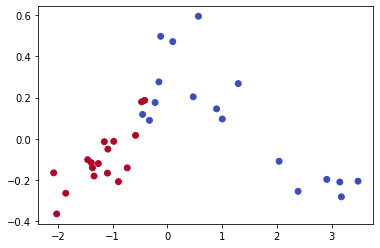

In [17]:
#plot 
plt.scatter(lowdimension_embedding[:,0], lowdimension_embedding[:,1],c=labels,s=35,cmap = 'coolwarm')
plt.show()

In [19]:
#use the embeding to obtain predictions
x_train, x_test,y_train,y_test = train_test_split(embedding, labels, test_size = 0.3)
ML_model = LogisticRegression(random_state=0).fit(x_train,y_train)
y_predict = ML_model.predict(x_test)
ML_acc = roc_auc_score(y_test,y_predict)
print(f'Node2Vec AUC: {ML_acc}')

Node2Vec AUC: 0.9166666666666667


The Node2Vec perfomed a little bit better than the deep walk by around 2%

## Node2Vec example torch geometric
https://github.com/pyg-team/pytorch_geometric/blob/master/examples/node2vec.py

In [47]:
import torch
# def format_pytorch_version(version):
#   return version.split('+')[0]

# TORCH_version = torch.__version__
# TORCH = format_pytorch_version(TORCH_version)

# def format_cuda_version(version):
#   return 'cu' + version.replace('.', '')

# CUDA_version = torch.version.cuda
# CUDA = format_cuda_version(CUDA_version)

# !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-geometric 

from torch_geometric.datasets import Planetoid #"Cora"
from torch_geometric.nn import Node2Vec
from sklearn.manifold import TSNE

In [24]:
#get data
path = "C:/home/maza/Desktop"   # directory
dataset = Planetoid(path,"Cora")

Processing...
Done!


In [37]:
data = dataset[0]   #tensro representation of planetiod cora 
#x = features, y = labels, edge_index = edge list,  mask = split fro training
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [38]:
#construct the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Node2Vec_model2 = Node2Vec(data.edge_index, embedding_dim = 128,walk_length=20,
                           context_size=10,walks_per_node=10,
                           num_negative_samples=1,p=1,q=1,sparse =True).to(device)
                        

In [42]:
#dataset is big so we use batches 
                                  #batch            #randomise     #num cores
loader = Node2Vec_model2.loader(batch_size = 128,shuffle=True, num_workers = 4)
optimizer = torch.optim.SparseAdam(list(Node2Vec_model2.parameters()), lr = 0.01)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [45]:
# train the model  GO BACK TO THIS 
#fit of the model 
def train():
  Node2Vec_model2.train()    #ste training as true
  total_loss = 0 
  for pos_rw, neg_rw in loader:
    optimizer.zero_grad()   #reset of gradient of all variables 
    loss = Node2Vec_model2.loss(pos_rw, neg_rw)
    loss.backward()
    optimizer.step()
    total_loss=+loss.item()
  return total_loss/len(loader)



In [52]:
#embedding
for epoch in range(1,101):
  loss = train()
  print(f'Epoch: {epoch:02d}, loss: {loss:.4f}')


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 01, loss: 0.1495
Epoch: 02, loss: 0.1267
Epoch: 03, loss: 0.1089
Epoch: 04, loss: 0.0981
Epoch: 05, loss: 0.0852
Epoch: 06, loss: 0.0765
Epoch: 07, loss: 0.0686
Epoch: 08, loss: 0.0646
Epoch: 09, loss: 0.0578
Epoch: 10, loss: 0.0546
Epoch: 11, loss: 0.0508
Epoch: 12, loss: 0.0492
Epoch: 13, loss: 0.0478
Epoch: 14, loss: 0.0464
Epoch: 15, loss: 0.0439
Epoch: 16, loss: 0.0436
Epoch: 17, loss: 0.0424
Epoch: 18, loss: 0.0418
Epoch: 19, loss: 0.0415
Epoch: 20, loss: 0.0414
Epoch: 21, loss: 0.0407
Epoch: 22, loss: 0.0403
Epoch: 23, loss: 0.0403
Epoch: 24, loss: 0.0398
Epoch: 25, loss: 0.0408
Epoch: 26, loss: 0.0393
Epoch: 27, loss: 0.0399
Epoch: 28, loss: 0.0395
Epoch: 29, loss: 0.0383
Epoch: 30, loss: 0.0386
Epoch: 31, loss: 0.0384
Epoch: 32, loss: 0.0384
Epoch: 33, loss: 0.0389
Epoch: 34, loss: 0.0388
Epoch: 35, loss: 0.0386
Epoch: 36, loss: 0.0387
Epoch: 37, loss: 0.0391
Epoch: 38, loss: 0.0384
Epoch: 39, loss: 0.0377
Epoch: 40, loss: 0.0391
Epoch: 41, loss: 0.0376
Epoch: 42, loss:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


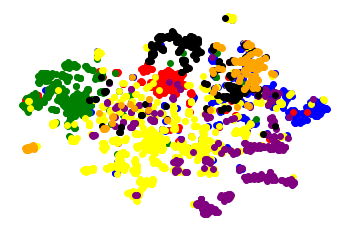

In [53]:
#plot embedding representation
@torch.no_grad()     #deactivate autograd functionality
def plot_point(colors):
  Node2Vec_model2.eval()    #evaluate the model based on the trained parameters
  z = Node2Vec_model2(torch.arange(data.num_nodes,device = device))   #embedding represenattion
  z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
  y = data.y.cpu().numpy()
  plt.figure()
  for i in range(dataset.num_classes):
    plt.scatter(z[y==i,0],z[y==i,1],s=35,c=colors[i])
  plt.axis('off')
  plt.show()
colors = ['blue','red','green','yellow','purple','black','orange']
plot_point(colors)

In [55]:
#node classification
def test():
  Node2Vec_model2.eval() # evaluate the model based on trained parameters
  z = Node2Vec_model2()
  acc = Node2Vec_model2.test(z[data.train_mask],data.y[data.train_mask],z[data.test_mask],data.y[data.test_mask],max_iter = 150)
  return acc


In [56]:
print(f'Accuracy: {test()}')

Accuracy: 0.72
